# 미니 프로젝트 (04/29 ~ 05/01)
- API를 통해서 라이엇 데이터 수집하기(getrawdata 함수로 DF만들기) - 티어는 자유
- 불러온 데이터를 전처리하기(중복제거, na값 제거) matches, timeline 합쳐서 최소 컬럼 25개
- 위의 과정을 함수화해서 모듈 만들기 (my_utils에 넣기)
- 전처리된 로우데이터를 오라클에 저장하기 -> 최소 5만개
- 팀과 함께 상의해서 흥미롭고 재밌을 것 같은 주제 3가지 선정
- 지표분석을 통해 나온 DF를 시각화 모듈을 사용해서 표현하세요 (3개중 2개 필수)
- 전처리부터 시각화까지 캡쳐해서 폴더에 저장
- ppt를 만들어서 간단하게 발표예정
- 모든 py파일, ipynb파일, 사진, ppt 다 하나의 폴더로 압축
- appfa@gameeye.co.kr
- 수요일 오전까지 제출, 오후에 발표

In [1]:
import requests
import random
import pandas as pd
import time
from tqdm import tqdm
from my_utils import *
import random

In [2]:
riot_api_key='RGAPI-4445a220-fdde-47a7-a07f-258499614db7'

In [3]:
def get_puu_id(summoner_id,riot_api_key):
    url = f'https://kr.api.riotgames.com/lol/summoner/v4/summoners/{summoner_id}?api_key={riot_api_key}'
    res = requests.get(url).json()
    puu_id = res['puuid']
    return puu_id

In [4]:
def get_match_ids(puu_id,riot_api_key,page=20):
    url = f'https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{puu_id}/ids?type=ranked&start=0&count={page}&api_key={riot_api_key}'
    res = requests.get(url).json()
    return res

In [5]:
def get_matches_timelines(match_ids,riot_api_key, tier):
    match_info_list = []
    for match_id in tqdm(match_ids):
        url1 = f'https://asia.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key={riot_api_key}'
        url2 = f'https://asia.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline?api_key={riot_api_key}'
        res1 = requests.get(url1).json()
        res2 = requests.get(url2).json()
        match_info_list.append([match_id,res1,res2, tier])
    return match_info_list

In [6]:
def get_rawdata(tier):
    # 원하는 티어를 넣으면 해당 디비전에 속한 사람들 특정 몇명만 뽑는 로직
    summoner_id_list = []
    lst = []
    puu_id_list= []
    divisions = ['I','II','III','IV']
    page = random.randrange(1,51)

    print('get SummonerId')
    for division in tqdm(divisions):
        url = f'https://kr.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/{tier}/{division}?page={page}&api_key={riot_api_key}'
        res = requests.get(url).json()
        #res에 있는 데이터들 중에 랜덤으로 3개를 출력해라. 
        lst += random.sample(res,3)
    summoner_id_list = list(map(lambda x:x['summonerId'],lst))
    
    
    # 위에서 뽑은 사람들의 puu_id를 가져오는 로직
    puu_id_list=[]
    print('get PUUID......')
    for summoner_id in tqdm(summoner_id_list):
        puu_id = get_puu_id(summoner_id,riot_api_key)
        puu_id_list.append(puu_id)
    # puu_id들을 통해 match_id들을 뽑는 로직
    
    print('get match id.....')
    match_id_lst = []
    for p in tqdm(puu_id_list):
        match_ids = get_match_ids(p,riot_api_key,2)
        match_id_lst.extend(match_ids)
        
    # match_id를 통해 match_id / matches / timelines가 들어있는 데이터 프레임 만들기 
    print('get maches&timeline....')
    df_create = get_matches_timelines(match_id_lst, riot_api_key, tier)
    df = pd.DataFrame(df_create,columns = ['match_id','matches','timeline', 'tier'])
    
    # get_maches_time(ines)
    df_info = []
    print('소환사 스텟 생성중 ... ')
    for i in tqdm(range(len(df))):
        try:
            if df.iloc[i].matches['info']['gameDuration'] > 780: # 게임이 10분 이상 되지 않은 경우
                for j in range(10):
                    tmp = []
                    info = df.iloc[i].matches['info']
                    tmp.append(info['participants'][j]['teamId'])
                    tmp.append(info['gameId'])
                    tmp.append(info['participants'][j]['participantId'])
                    tmp.append(df.iloc[i].tier)
                    tmp.append(info['participants'][j]['riotIdTagline'])
                    tmp.append(info['participants'][j]['riotIdGameName'])
                    tmp.append(info['participants'][j]['championName'])
                    tmp.append(info['participants'][j]['teamPosition'])
                    tmp.append(info['gameVersion'])
                    tmp.append(info['gameDuration'])
                    tmp.append(info['participants'][j]['summoner1Id'])
                    tmp.append(info['participants'][j]['summoner2Id'])
                    tmp.append(info['participants'][j]['summoner1Casts'])
                    tmp.append(info['participants'][j]['summoner2Casts'])
                    tmp.append(info['participants'][j]['wardsPlaced'])

                    pink_ward = 0
                    for k in range(len(df.iloc[i].timeline['info']['frames'])) :
                        for p in range(len(df.iloc[i].timeline['info']['frames'][k]['events'])):
                            try :
                                if df.iloc[i].timeline['info']['frames'][k]['events'][p]['type'] == 'ITEM_PURCHASED' : 
                                    if df.iloc[i].timeline['info']['frames'][k]['events'][p]['itemId'] == 2055 :
                                        #print(f"{str(k)}분 제어와드 구입")
                                        pink_ward += 1
                            except :
                                print("오류")
                    print(f'----------------{i}번째 게임 끝----------------')

                    tmp.append(pink_ward)

                    tmp.append(info['participants'][j]['kills'])
                    tmp.append(info['participants'][j]['deaths'])
                    tmp.append(info['participants'][j]['assists'])
                    tmp.append(info['participants'][j]['win'])
                    # timelines 뽑아낼 G5 ~ G26까지의 데이터
                    for k in range(5,11):
                        try:
                            tmp.append(df.iloc[i].timeline['info']['frames'][k]['participantFrames'][str(j+1)]['totalGold'])
                        except:
                            tmp.append(0)
                    
                    df_info.append(tmp)
        except Exception as e:
                print(e)
                continue
    columns = ['teamId','gameId','participantId','tier','riotTag','playerNickname','championName','teamPosition',
    'gameVersion','gameDuration','Spell_type_1','Spell_type_2','Spell_type_1_used','Spell_type_2_used','wardUsed','itemId','kills','deaths'
               ,'assists','win','g_5','g_6','g_7','g_8','g_9','g_10']
    df_list = pd.DataFrame(df_info, columns = columns).drop_duplicates()
    print('현재 df의 수는 %d입니다.'%len(df_list))

    
    return df_list

In [7]:
tier_list = ['SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND']
# for tier in tier_list:

In [8]:
query = '''
create table lol_min_datas(
    teamId number(20), 
    gameId varchar(30), 
    participantId number(5), 
    tier varchar(20), 
    riotTag varchar(30), 
    playerNickname varchar(100), 
    championName varchar(50), 
    teamPosition varchar(50), 
    gameVersion varchar(40), 
    gameDuration number(20), 
    Spell_type_1 varchar(50), 
    Spell_type_2 varchar(50), 
    Spell_type_1_used number(5), 
    Spell_type_2_used number(5), 
    wardUsed number(5), 
    itemId varchar(50), 
    kills number(20), 
    deaths number(20), 
    assists number(20), 
    win varchar(50),  
    g_5 number(20), 
    g_6 number(20), 
    g_7 number(20), 
    g_8 number(20), 
    g_9 number(20),
    g_10 number(20),
    constraint lol_pk primary key(gameId, participantId)
)
'''

In [9]:
db_open()
sql_execute(query)
db_close()

oracle 쿼리 성공
오라클 정상적으로 닫힘


In [9]:
def insert_data(x):
    query = (
        f"MERGE INTO lol_min_datas USING DUAL ON (gameId = {repr(x.gameId)} AND participantId = {x.participantId}) "
        f"WHEN NOT MATCHED THEN "
        f"INSERT (teamId, gameId, participantId, tier, riotTag, "
        f"playerNickname, championName, teamPosition, gameVersion, gameDuration, "
        f"Spell_type_1, Spell_type_2, Spell_type_1_used, Spell_type_2_used, wardUsed, itemId, kills, deaths, assists, win, "
        f"g_5, g_6, g_7, g_8, g_9, g_10) "
        f"VALUES ({x.teamId}, {repr(x.gameId)}, {x.participantId}, "
        f"{repr(x.tier)}, {repr(x.riotTag)}, {repr(x.playerNickname)},{repr(x.championName)}, {repr(x.teamPosition)}, {repr(str(x.gameVersion))}, {x.gameDuration}, "
        f"{repr(x.Spell_type_1)}, {repr(x.Spell_type_2)}, {x.Spell_type_1_used}, {x.Spell_type_2_used}, {x.wardUsed}, {repr(x.itemId)}, {x.kills}, {x.deaths}, {x.assists},{repr(str(x.win))}, "
        f"{x.g_5}, {x.g_6}, {x.g_7}, {x.g_8}, {x.g_9}, {x.g_10})"
    )
    sql_execute(query)

In [ ]:
tqdm.pandas()
tier_list = ['SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND']
for i in range(100000000000):
    for t in tier_list :
        try:
            db_open()
            df = get_rawdata(t)
            df.progress_apply(lambda x :insert_data(x) ,axis=1) #insert 코드
            db_close()
            time.sleep(100) # riot api는 2분에 100개
        except Exception as e:
            print(e)
            time.sleep(100)
            continue

get SummonerId


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.28it/s]


get PUUID......


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.49it/s]


get match id.....


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.48it/s]


get maches&timeline....


 38%|███████████████████████████████▏                                                   | 9/24 [00:13<00:21,  1.43s/it]

In [10]:
db_open()
test_df = sql_execute('select * from lol_min_datas')
db_close()

C:\Users\user\게임아이 수업자료\my_utils.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql=query, con=db)


오라클 정상적으로 닫힘


In [11]:
test_df

,TEAMID,GAMEID,PARTICIPANTID,TIER,RIOTTAG,PLAYERNICKNAME,CHAMPIONNAME,TEAMPOSITION,GAMEVERSION,GAMEDURATION,...,KILLS,DEATHS,ASSISTS,WIN,G_5,G_6,G_7,G_8,G_9,G_10
0,100,7047813540,1,SILVER,KR1,짜 닛,Malphite,TOP,14.8.578.3867,1782,...,8,3,11,True,1518,1728,2132,2791,3047,3346
1,100,7047813540,2,SILVER,KR1,스파게티불닭,Nocturne,JUNGLE,14.8.578.3867,1782,...,3,6,10,True,1984,2215,2493,2764,3110,3342
2,100,7047813540,3,SILVER,KR1,뒤보면나있다,Xerath,MIDDLE,14.8.578.3867,1782,...,5,7,7,True,1312,1773,1960,2326,2448,2811
3,100,7047813540,4,SILVER,KR1,YG Blackpink,Jhin,BOTTOM,14.8.578.3867,1782,...,12,6,6,True,2054,2327,2626,2846,3409,3813
4,100,7047813540,5,SILVER,KR1,MH401,Rumble,UTILITY,14.8.578.3867,1782,...,6,8,20,True,1436,1663,1921,2194,2496,2672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112055,100,7038251282,1,GOLD,2400,2400번째 에어맨,Yone,TOP,14.8.576.8838,1828,...,2,6,3,False,1438,1739,1889,2223,2512,2676
112056,100,7038251282,2,GOLD,KR1,상위1프로몸매,Evelynn,JUNGLE,14.8.576.8838,1828,...,3,5,7,False,1732,2052,2371,2665,2819,3127
112057,100,7038251282,3,GOLD,KR1,55MPCO KIA,Irelia,MIDDLE,14.8.576.8838,1828,...,12,3,0,False,1765,2389,2595,3327,3707,4581
112058,100,7038251282,4,GOLD,KR1,뚜루룽,Lucian,BOTTOM,14.8.576.8838,1828,...,2,8,7,False,1403,1760,2113,2538,2818,3171


# 와드 그래프

In [12]:
query = '''
SELECT
    TIER,
    ROUND(AVG(WARDUESD_SUM),2) AS AVG_WARDUESD_SUM,
    ROUND(AVG(ITEMID_SUM),2) AS AVG_ITEMID_SUM
FROM
    (
        SELECT
            TIER,
            GAMEID,
            SUM(WARDUSED) AS WARDUESD_SUM,
            SUM(ITEMID)/10 AS ITEMID_SUM
        FROM
            lol_min_datas
        GROUP BY
            TIER, GAMEID
    )
GROUP BY TIER
'''

In [13]:
db_open()
ward_df = sql_execute(query)
db_close()

오라클 정상적으로 닫힘


C:\Users\user\게임아이 수업자료\my_utils.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql=query, con=db)


In [14]:
ward_df

,TIER,AVG_WARDUESD_SUM,AVG_ITEMID_SUM
0,SILVER,114.49,22.45
1,GOLD,116.67,25.00
2,PLATINUM,120.57,28.15
3,EMERALD,123.06,30.38
4,DIAMOND,125.51,33.48


In [15]:
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc
font_path = "C:/Windows/Fonts/gulim.ttc"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

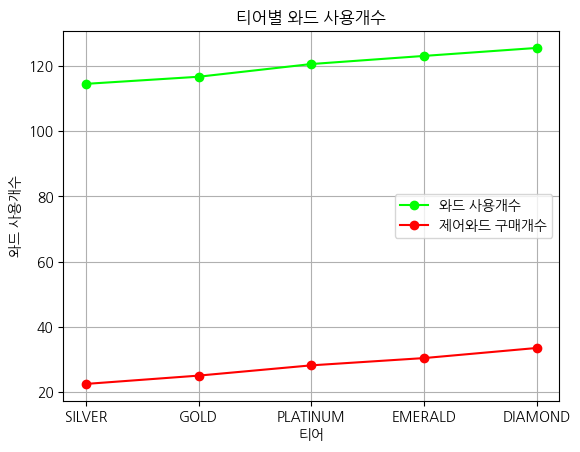

In [16]:
xdata = ward_df.TIER
ydata = ward_df.AVG_WARDUESD_SUM
ydata2 = ward_df.AVG_ITEMID_SUM

plt.figure()
plt.rcParams['font.family'] = 'NanumGothic'
plt.plot(xdata,ydata,color='lime', marker='o', label='와드 사용개수')
plt.plot(xdata,ydata2,color='r', marker='o', label='제어와드 구매개수')
plt.xlabel('티어')
plt.ylabel('와드 사용개수')
plt.title('티어별 와드 사용개수')
plt.grid(True)
plt.legend() 
plt.show()

# 스펠 그래프

In [17]:
s_query = '''
SELECT 
    CASE
        WHEN Combined_Spell = 1 THEN '정화'
        WHEN Combined_Spell = 3 THEN '탈진'
        WHEN Combined_Spell = 4 THEN '점멸'
        WHEN Combined_Spell = 6 THEN '유체화'
        WHEN Combined_Spell = 7 THEN '회복'
        WHEN Combined_Spell = 11 THEN '강타'
        WHEN Combined_Spell = 12 THEN '순간이동'
        WHEN Combined_Spell = 14 THEN '점화'
        WHEN Combined_Spell = 21 THEN '방어막'
        ELSE '기타'
    END AS Spell,
    SUM(Total_Usage) AS Total_Usage
FROM (
    SELECT SPELL_TYPE_1 AS Combined_Spell, SUM(SPELL_TYPE_1_USED) AS Total_Usage
    FROM lol_min_datas
    WHERE TIER = 'SILVER'
    GROUP BY SPELL_TYPE_1
    UNION
    SELECT SPELL_TYPE_2 AS Combined_Spell, SUM(SPELL_TYPE_2_USED) AS Total_Usage
    FROM lol_min_datas
    WHERE TIER = 'SILVER'
    GROUP BY SPELL_TYPE_2
)
GROUP BY Combined_Spell
order by 1
'''

In [18]:
g_query = '''
SELECT 
    CASE
        WHEN Combined_Spell = 1 THEN '정화'
        WHEN Combined_Spell = 3 THEN '탈진'
        WHEN Combined_Spell = 4 THEN '점멸'
        WHEN Combined_Spell = 6 THEN '유체화'
        WHEN Combined_Spell = 7 THEN '회복'
        WHEN Combined_Spell = 11 THEN '강타'
        WHEN Combined_Spell = 12 THEN '순간이동'
        WHEN Combined_Spell = 14 THEN '점화'
        WHEN Combined_Spell = 21 THEN '방어막'
        ELSE '기타'
    END AS Spell,
    SUM(Total_Usage) AS Total_Usage
FROM (
    SELECT SPELL_TYPE_1 AS Combined_Spell, SUM(SPELL_TYPE_1_USED) AS Total_Usage
    FROM lol_min_datas
    WHERE TIER = 'GOLD'
    GROUP BY SPELL_TYPE_1
    UNION
    SELECT SPELL_TYPE_2 AS Combined_Spell, SUM(SPELL_TYPE_2_USED) AS Total_Usage
    FROM lol_min_datas
    WHERE TIER = 'GOLD'
    GROUP BY SPELL_TYPE_2
)
GROUP BY Combined_Spell
order by 1
'''

In [19]:
p_query = '''
SELECT 
    CASE
        WHEN Combined_Spell = 1 THEN '정화'
        WHEN Combined_Spell = 3 THEN '탈진'
        WHEN Combined_Spell = 4 THEN '점멸'
        WHEN Combined_Spell = 6 THEN '유체화'
        WHEN Combined_Spell = 7 THEN '회복'
        WHEN Combined_Spell = 11 THEN '강타'
        WHEN Combined_Spell = 12 THEN '순간이동'
        WHEN Combined_Spell = 14 THEN '점화'
        WHEN Combined_Spell = 21 THEN '방어막'
        ELSE '기타'
    END AS Spell,
    SUM(Total_Usage) AS Total_Usage
FROM (
    SELECT SPELL_TYPE_1 AS Combined_Spell, SUM(SPELL_TYPE_1_USED) AS Total_Usage
    FROM lol_min_datas
    WHERE TIER = 'PLATINUM'
    GROUP BY SPELL_TYPE_1
    UNION
    SELECT SPELL_TYPE_2 AS Combined_Spell, SUM(SPELL_TYPE_2_USED) AS Total_Usage
    FROM lol_min_datas
    WHERE TIER = 'PLATINUM'
    GROUP BY SPELL_TYPE_2
)
GROUP BY Combined_Spell
order by 1
'''

In [20]:
e_query = '''
SELECT 
    CASE
        WHEN Combined_Spell = 1 THEN '정화'
        WHEN Combined_Spell = 3 THEN '탈진'
        WHEN Combined_Spell = 4 THEN '점멸'
        WHEN Combined_Spell = 6 THEN '유체화'
        WHEN Combined_Spell = 7 THEN '회복'
        WHEN Combined_Spell = 11 THEN '강타'
        WHEN Combined_Spell = 12 THEN '순간이동'
        WHEN Combined_Spell = 14 THEN '점화'
        WHEN Combined_Spell = 21 THEN '방어막'
        ELSE '기타'
    END AS Spell,
    SUM(Total_Usage) AS Total_Usage
FROM (
    SELECT SPELL_TYPE_1 AS Combined_Spell, SUM(SPELL_TYPE_1_USED) AS Total_Usage
    FROM lol_min_datas
    WHERE TIER = 'EMERALD'
    GROUP BY SPELL_TYPE_1
    UNION
    SELECT SPELL_TYPE_2 AS Combined_Spell, SUM(SPELL_TYPE_2_USED) AS Total_Usage
    FROM lol_min_datas
    WHERE TIER = 'EMERALD'
    GROUP BY SPELL_TYPE_2
)
GROUP BY Combined_Spell
order by 1
'''

In [21]:
d_query = '''
SELECT 
    CASE
        WHEN Combined_Spell = 1 THEN '정화'
        WHEN Combined_Spell = 3 THEN '탈진'
        WHEN Combined_Spell = 4 THEN '점멸'
        WHEN Combined_Spell = 6 THEN '유체화'
        WHEN Combined_Spell = 7 THEN '회복'
        WHEN Combined_Spell = 11 THEN '강타'
        WHEN Combined_Spell = 12 THEN '순간이동'
        WHEN Combined_Spell = 14 THEN '점화'
        WHEN Combined_Spell = 21 THEN '방어막'
        ELSE '기타'
    END AS Spell,
    SUM(Total_Usage) AS Total_Usage
FROM (
    SELECT SPELL_TYPE_1 AS Combined_Spell, SUM(SPELL_TYPE_1_USED) AS Total_Usage
    FROM lol_min_datas
    WHERE TIER = 'DIAMOND'
    GROUP BY SPELL_TYPE_1
    UNION
    SELECT SPELL_TYPE_2 AS Combined_Spell, SUM(SPELL_TYPE_2_USED) AS Total_Usage
    FROM lol_min_datas
    WHERE TIER = 'DIAMOND'
    GROUP BY SPELL_TYPE_2
)
GROUP BY Combined_Spell
order by 1
'''

In [22]:
db_open()
s_df = sql_execute(s_query)
db_close()

오라클 정상적으로 닫힘


C:\Users\user\게임아이 수업자료\my_utils.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql=query, con=db)


In [23]:
db_open()
g_df = sql_execute(g_query)
db_close()

오라클 정상적으로 닫힘


In [24]:
db_open()
p_df = sql_execute(p_query)
db_close()

오라클 정상적으로 닫힘


In [25]:
db_open()
e_df = sql_execute(e_query)
db_close()

오라클 정상적으로 닫힘


In [26]:
db_open()
d_df = sql_execute(d_query)
db_close()

오라클 정상적으로 닫힘


In [27]:
s_df

,SPELL,TOTAL_USAGE
0,강타,70847
1,방어막,656
2,순간이동,21126
3,유체화,17880
4,점멸,83167
5,점화,27600
6,정화,1745
7,탈진,6034
8,회복,11642


In [28]:
g_df

,SPELL,TOTAL_USAGE
0,강타,71542
1,방어막,612
2,순간이동,21981
3,유체화,19314
4,점멸,83163
5,점화,26959
6,정화,2060
7,탈진,6248
8,회복,10831


In [29]:
p_df

,SPELL,TOTAL_USAGE
0,강타,71045
1,방어막,644
2,순간이동,22821
3,유체화,19885
4,점멸,82170
5,점화,25379
6,정화,2136
7,탈진,6119
8,회복,10405


In [30]:
e_df

,SPELL,TOTAL_USAGE
0,강타,70288
1,방어막,625
2,순간이동,23962
3,유체화,20210
4,점멸,80850
5,점화,25220
6,정화,2555
7,탈진,5506
8,회복,9563


In [31]:
d_df

,SPELL,TOTAL_USAGE
0,강타,67936
1,방어막,581
2,순간이동,24633
3,유체화,21134
4,점멸,78365
5,점화,23940
6,정화,2537
7,탈진,4836
8,회복,8510


In [32]:
g_df = g_df.rename(columns={'TOTAL_USAGE':'GOLD_USAGE'})

In [33]:
p_df = p_df.rename(columns={'TOTAL_USAGE':'PLAT_USAGE'})

In [34]:
e_df = e_df.rename(columns={'TOTAL_USAGE':'EME_USAGE'})

In [35]:
d_df = d_df.rename(columns={'TOTAL_USAGE':'DIA_USAGE'})

In [36]:
d_df

,SPELL,DIA_USAGE
0,강타,67936
1,방어막,581
2,순간이동,24633
3,유체화,21134
4,점멸,78365
5,점화,23940
6,정화,2537
7,탈진,4836
8,회복,8510


In [37]:
result = pd.merge(s_df, g_df, on=['SPELL'])

In [38]:
result = pd.merge(result, p_df, on=['SPELL'])

In [39]:
result = pd.merge(result, e_df, on=['SPELL'])

In [40]:
result = pd.merge(result, d_df, on=['SPELL'])

In [41]:
result = result.rename(columns={'TOTAL_USAGE':'SILVER_USAGE'})

In [42]:
result  = result.rename(columns={'SILVER_USAGE':'실버', 'GOLD_USAGE':'골드', 'PLAT_USAGE':'플레티넘', 'EME_USAGE':'에메랄드', 'DIA_USAGE':'다이아'})

In [43]:
result

,SPELL,실버,골드,플레티넘,에메랄드,다이아
0,강타,70847,71542,71045,70288,67936
1,방어막,656,612,644,625,581
2,순간이동,21126,21981,22821,23962,24633
3,유체화,17880,19314,19885,20210,21134
4,점멸,83167,83163,82170,80850,78365
5,점화,27600,26959,25379,25220,23940
6,정화,1745,2060,2136,2555,2537
7,탈진,6034,6248,6119,5506,4836
8,회복,11642,10831,10405,9563,8510


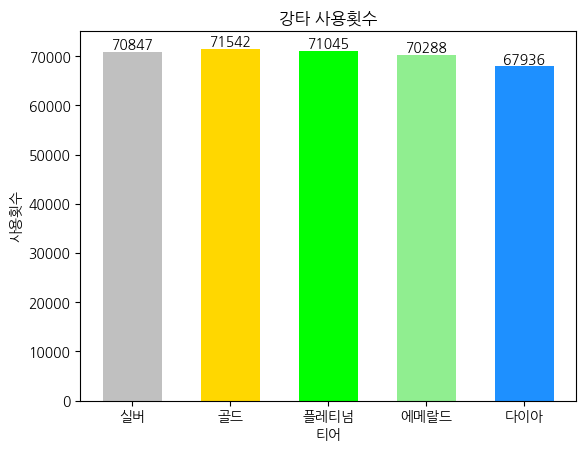

In [57]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
plt.figure()
bar = plt.bar(result.iloc[0].index[1:], result.iloc[0].values[1:], color=['silver','gold','lime','lightgreen','dodgerblue'], width = 0.6)
for i in bar:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width()/2, h, int(h), ha='center', va='bottom', size=10)
plt.xlabel('티어')
plt.ylabel('사용횟수')
plt.title('강타 사용횟수')
plt.show()

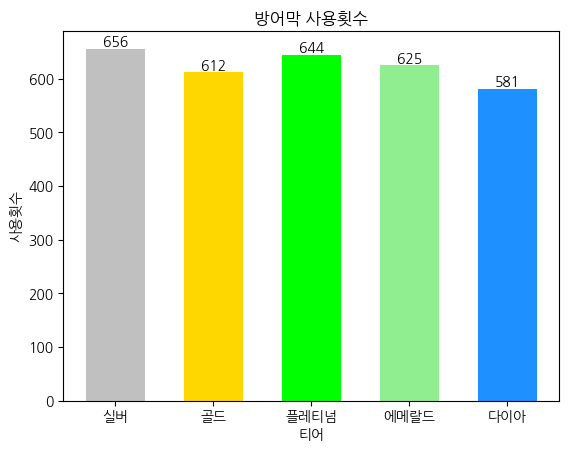

In [58]:
plt.figure()
plt.rcParams['font.family'] = 'NanumGothic'
bar = plt.bar(result.iloc[1].index[1:], result.iloc[1].values[1:], color=['silver','gold','lime','lightgreen','dodgerblue'], width = 0.6)
for i in bar:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width()/2, h, int(h), ha='center', va='bottom', size=10)
plt.xlabel('티어')
plt.ylabel('사용횟수')
plt.title('방어막 사용횟수')
plt.show()

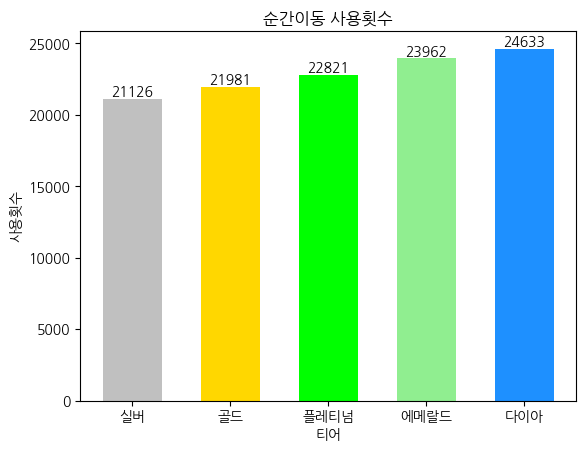

In [59]:
plt.figure()
plt.rcParams['font.family'] = 'NanumGothic'
bar = plt.bar(result.iloc[2].index[1:], result.iloc[2].values[1:], color=['silver','gold','lime','lightgreen','dodgerblue'], width = 0.6)
for i in bar:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width()/2, h, int(h), ha='center', va='bottom', size=10)
plt.xlabel('티어')
plt.ylabel('사용횟수')
plt.title('순간이동 사용횟수')
plt.show()

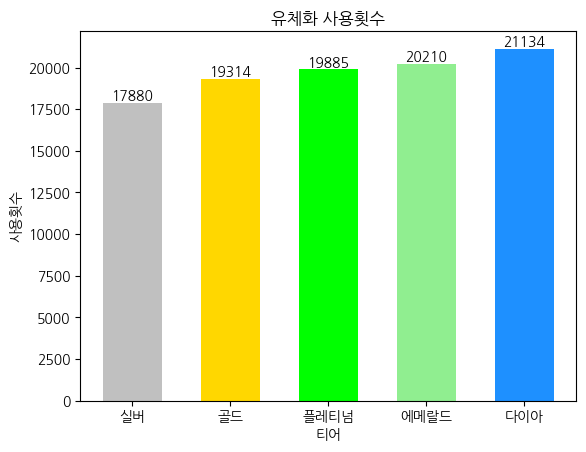

In [60]:
plt.figure()
plt.rcParams['font.family'] = 'NanumGothic'
bar = plt.bar(result.iloc[3].index[1:], result.iloc[3].values[1:], color=['silver','gold','lime','lightgreen','dodgerblue'], width=0.6)
for i in bar:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width()/2, h, int(h), ha='center', va='bottom', size=10)
plt.xlabel('티어')
plt.ylabel('사용횟수')
plt.title('유체화 사용횟수')
plt.show()

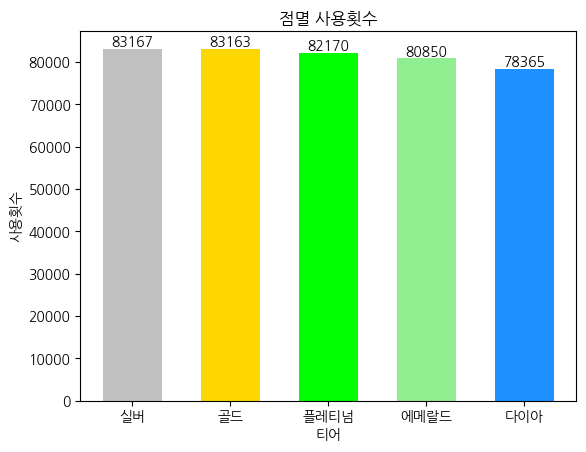

In [61]:
plt.figure()
plt.rcParams['font.family'] = 'NanumGothic'
bar = plt.bar(result.iloc[4].index[1:], result.iloc[4].values[1:], color=['silver','gold','lime','lightgreen','dodgerblue'], width=0.6)
for i in bar:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width()/2, h, int(h), ha='center', va='bottom', size=10)
plt.xlabel('티어')
plt.ylabel('사용횟수')
plt.title('점멸 사용횟수')
plt.show()

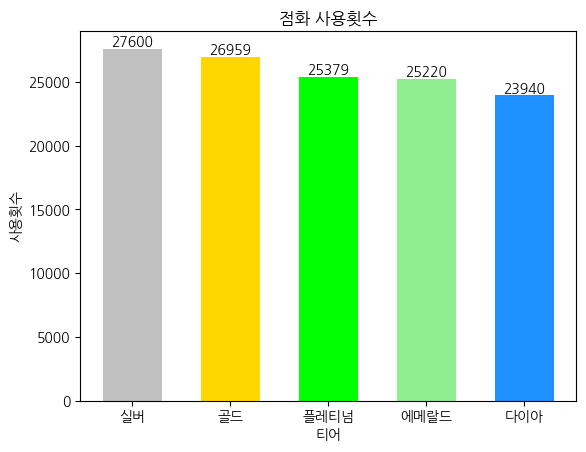

In [62]:
plt.figure()
plt.rcParams['font.family'] = 'NanumGothic'
bar = plt.bar(result.iloc[5].index[1:], result.iloc[5].values[1:], color=['silver','gold','lime','lightgreen','dodgerblue'], width = 0.6)
for i in bar:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width()/2, h, int(h), ha='center', va='bottom', size=10)
plt.xlabel('티어')
plt.ylabel('사용횟수')
plt.title('점화 사용횟수')
plt.show()

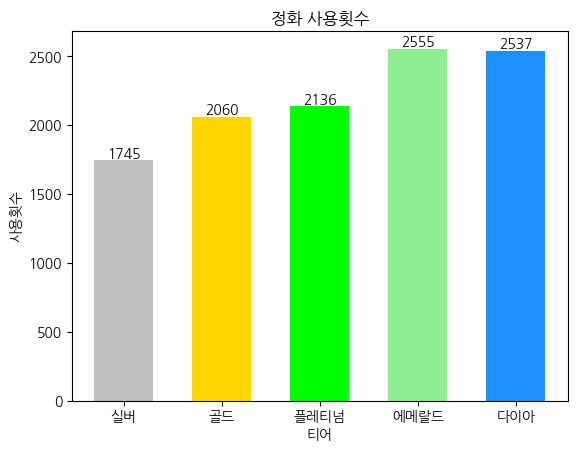

In [63]:
plt.figure()
plt.rcParams['font.family'] = 'NanumGothic'
bar = plt.bar(result.iloc[6].index[1:], result.iloc[6].values[1:], color=['silver','gold','lime','lightgreen','dodgerblue'], width = 0.6)
for i in bar:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width()/2, h, int(h), ha='center', va='bottom', size=10)
plt.xlabel('티어')
plt.ylabel('사용횟수')
plt.title('정화 사용횟수')
plt.show()

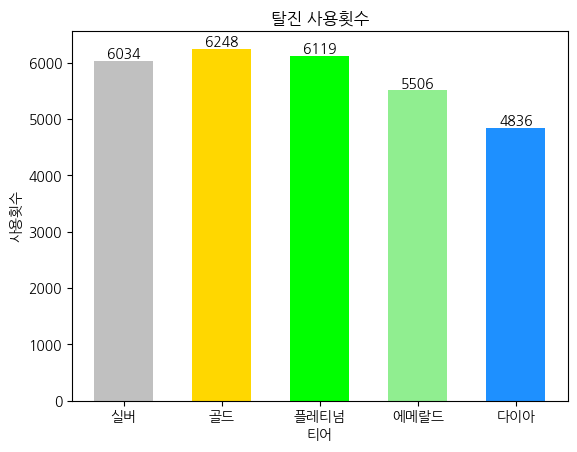

In [64]:
plt.figure()
plt.rcParams['font.family'] = 'NanumGothic'
bar = plt.bar(result.iloc[7].index[1:], result.iloc[7].values[1:], color=['silver','gold','lime','lightgreen','dodgerblue'], width = 0.6)
for i in bar:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width()/2, h, int(h), ha='center', va='bottom', size=10)
plt.xlabel('티어')
plt.ylabel('사용횟수')
plt.title('탈진 사용횟수')
plt.show()

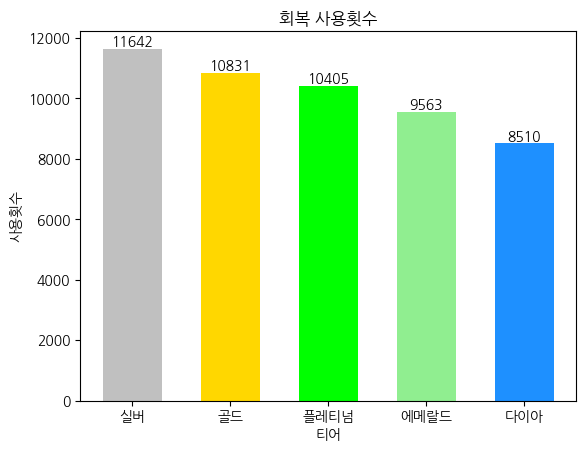

In [65]:
plt.figure()
plt.rcParams['font.family'] = 'NanumGothic'
bar = plt.bar(result.iloc[8].index[1:], result.iloc[8].values[1:], color=['silver','gold','lime','lightgreen','dodgerblue'], width = 0.6)
for i in bar:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width()/2, h, int(h), ha='center', va='bottom', size=10)
plt.xlabel('티어')
plt.ylabel('사용횟수')
plt.title('회복 사용횟수')
plt.show()

# 티어별 점멸 선호키

In [66]:
db_open()

In [67]:
df_SILVER = sql_execute("""SELECT
    round(sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END)/(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)+sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END))*100,2) AS SPELL_TYPE_1_COUNT,
    round(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)/(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)+sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END))*100,2) AS SPELL_TYPE_2_COUNT
FROM
    lol_min_datas
where tier = 'SILVER'
""")

C:\Users\user\게임아이 수업자료\my_utils.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql=query, con=db)


In [68]:
df_GOLD = sql_execute("""SELECT
    round(sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END)/(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)+sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END))*100,2) AS SPELL_TYPE_1_COUNT,
    round(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)/(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)+sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END))*100,2) AS SPELL_TYPE_2_COUNT
FROM
    lol_min_datas
where tier = 'GOLD'
""")

In [69]:
df_PLATINUM = sql_execute("""SELECT
    round(sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END)/(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)+sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END))*100,2) AS SPELL_TYPE_1_COUNT,
    round(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)/(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)+sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END))*100,2) AS SPELL_TYPE_2_COUNT
FROM
    lol_min_datas
where tier = 'PLATINUM'
""")

In [70]:
df_EMERALD = sql_execute("""SELECT
    round(sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END)/(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)+sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END))*100,2) AS SPELL_TYPE_1_COUNT,
    round(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)/(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)+sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END))*100,2) AS SPELL_TYPE_2_COUNT
FROM
    lol_min_datas
where tier = 'EMERALD'
""")

In [71]:
df_DIAMOND = sql_execute("""SELECT
    round(sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END)/(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)+sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END))*100,2) AS SPELL_TYPE_1_COUNT,
    round(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)/(sum(CASE WHEN SPELL_TYPE_2 = 4 THEN 1 ELSE 0 END)+sum(CASE WHEN SPELL_TYPE_1 = 4 THEN 1 ELSE 0 END))*100,2) AS SPELL_TYPE_2_COUNT
FROM
    lol_min_datas
where tier = 'DIAMOND'
""")

In [72]:
df_SILVER

,SPELL_TYPE_1_COUNT,SPELL_TYPE_2_COUNT
0,22.46,77.54


In [73]:
df_GOLD

,SPELL_TYPE_1_COUNT,SPELL_TYPE_2_COUNT
0,23.41,76.59


In [74]:
df_PLATINUM

,SPELL_TYPE_1_COUNT,SPELL_TYPE_2_COUNT
0,23.44,76.56


In [75]:
df_EMERALD

,SPELL_TYPE_1_COUNT,SPELL_TYPE_2_COUNT
0,24.47,75.53


In [76]:
df_DIAMOND

,SPELL_TYPE_1_COUNT,SPELL_TYPE_2_COUNT
0,25.47,74.53


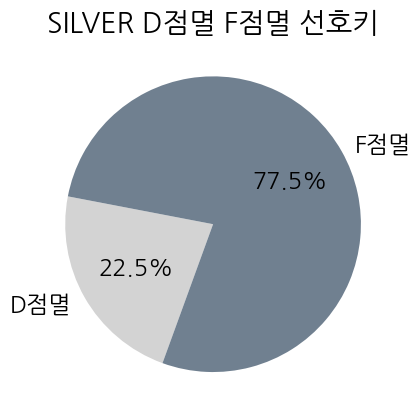

In [77]:
import matplotlib.pyplot as plt
# f : gold , D : 
list = [df_SILVER.loc[0].SPELL_TYPE_1_COUNT,df_SILVER.loc[0].SPELL_TYPE_2_COUNT]
list
plt.rc('font', size=17)
plt.title("SILVER D점멸 F점멸 선호키")
plt.pie(list,labels=["D점멸","F점멸"], autopct='%.1f%%', startangle=250, counterclock=False, colors=['lightgray','slategrey'])
plt.show()

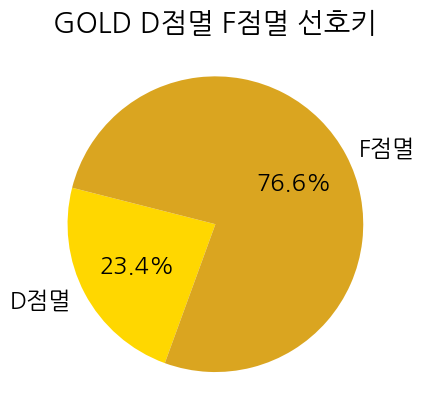

In [78]:
import matplotlib.pyplot as plt

list = [df_GOLD.loc[0].SPELL_TYPE_1_COUNT,df_GOLD.loc[0].SPELL_TYPE_2_COUNT]
plt.rc('font', size=17)
plt.title("GOLD D점멸 F점멸 선호키")
plt.pie(list,labels=["D점멸","F점멸"], autopct='%.1f%%', startangle=250, counterclock=False,colors=['gold','goldenrod'])
plt.show()

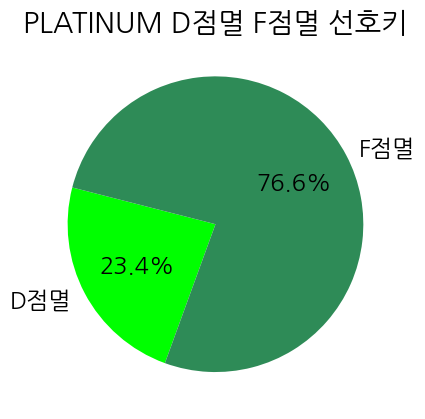

In [79]:
import matplotlib.pyplot as plt

list = [df_PLATINUM.loc[0].SPELL_TYPE_1_COUNT,df_PLATINUM.loc[0].SPELL_TYPE_2_COUNT]
plt.rc('font', size=17)
plt.title("PLATINUM D점멸 F점멸 선호키")
plt.pie(list,labels=["D점멸","F점멸"], autopct='%.1f%%', startangle=250, counterclock=False,colors=['lime','seagreen'])
plt.show()

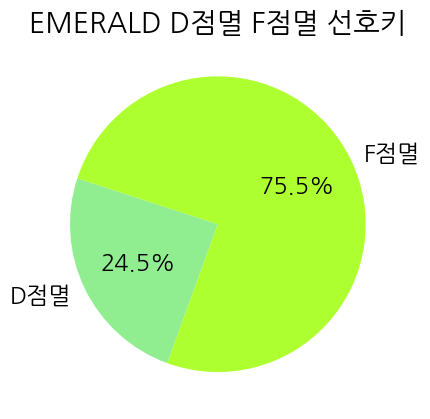

In [80]:
import matplotlib.pyplot as plt

list = [df_EMERALD.loc[0].SPELL_TYPE_1_COUNT,df_EMERALD.loc[0].SPELL_TYPE_2_COUNT]
plt.rc('font', size=17)
plt.title("EMERALD D점멸 F점멸 선호키")
plt.pie(list,labels=["D점멸","F점멸"], autopct='%.1f%%', startangle=250, counterclock=False,colors=['lightgreen','greenyellow'])
plt.show()

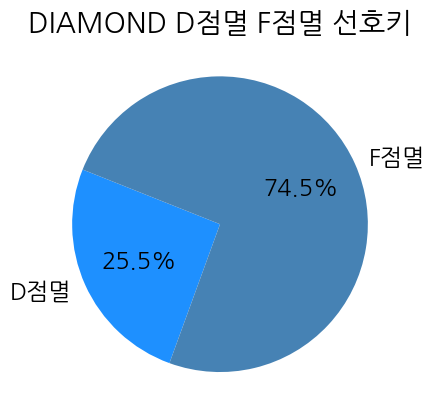

In [81]:
import matplotlib.pyplot as plt

list = [df_DIAMOND.loc[0].SPELL_TYPE_1_COUNT,df_DIAMOND.loc[0].SPELL_TYPE_2_COUNT]
plt.rc('font', size=17)
plt.title("DIAMOND D점멸 F점멸 선호키")
plt.pie(list,labels=["D점멸","F점멸"], autopct='%.1f%%', startangle=250, counterclock=False,colors=['dodgerblue','steelblue'])
plt.show()

In [82]:
db_close()

오라클 정상적으로 닫힘


# 티어별 챔피언 승률 (상위 10개)

In [83]:
db_open()

In [84]:
df_SILVER_win =sql_execute("""
select championName, tier, ROUND(count(case when win = 'True' then 1 END)/count(*)*100,2) AS WINRATE, COUNT(*)
from lol_min_datas 
WHERE TIER = 'SILVER' 
group by championName,tier 
HAVING COUNT(*) > 50 
order by 3 DESC
""")

C:\Users\user\게임아이 수업자료\my_utils.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql=query, con=db)


In [85]:
df_GOLD_win =sql_execute("""
select championName, tier, ROUND(count(case when win = 'True' then 1 END)/count(*)*100,2) AS WINRATE, COUNT(*)
from lol_min_datas 
WHERE TIER = 'GOLD' 
group by championName,tier 
HAVING COUNT(*) > 50 
order by 3 DESC
""")

In [86]:
df_PLATINUM_win =sql_execute("""
select championName, tier, ROUND(count(case when win = 'True' then 1 END)/count(*)*100,2) AS WINRATE, COUNT(*)
from lol_min_datas 
WHERE TIER = 'PLATINUM' 
group by championName,tier 
HAVING COUNT(*) > 50 
order by 3 DESC
""")

In [87]:
df_EMERALD_win =sql_execute("""
select championName, tier, ROUND(count(case when win = 'True' then 1 END)/count(*)*100,2) AS WINRATE, COUNT(*)
from lol_min_datas 
WHERE TIER = 'EMERALD' 
group by championName,tier 
HAVING COUNT(*) > 50 
order by 3 DESC
""")

In [88]:
df_DIAMOND_win =sql_execute("""
select championName, tier, ROUND(count(case when win = 'True' then 1 END)/count(*)*100,2) AS WINRATE, COUNT(*)
from lol_min_datas 
WHERE TIER = 'DIAMOND' 
group by championName,tier 
HAVING COUNT(*) > 50 
order by 3 DESC
""")

In [89]:
df_SILVER_win = df_SILVER_win[:10]
df_GOLD_win = df_GOLD_win[:10]
df_PLATINUM_win = df_PLATINUM_win[:10]
df_EMERALD_win = df_EMERALD_win[:10]
df_DIAMOND_win = df_DIAMOND_win[:10]

In [90]:
df_SILVER_win

,CHAMPIONNAME,TIER,WINRATE,COUNT(*)
0,Amumu,SILVER,65.88,85
1,Galio,SILVER,63.77,69
2,Rammus,SILVER,63.53,85
3,Kindred,SILVER,63.16,76
4,RekSai,SILVER,62.90,62
5,Sivir,SILVER,62.16,74
6,Milio,SILVER,61.64,73
7,Zyra,SILVER,59.68,124
8,Sett,SILVER,59.48,153
9,DrMundo,SILVER,59.48,116


<BarContainer object of 10 artists>

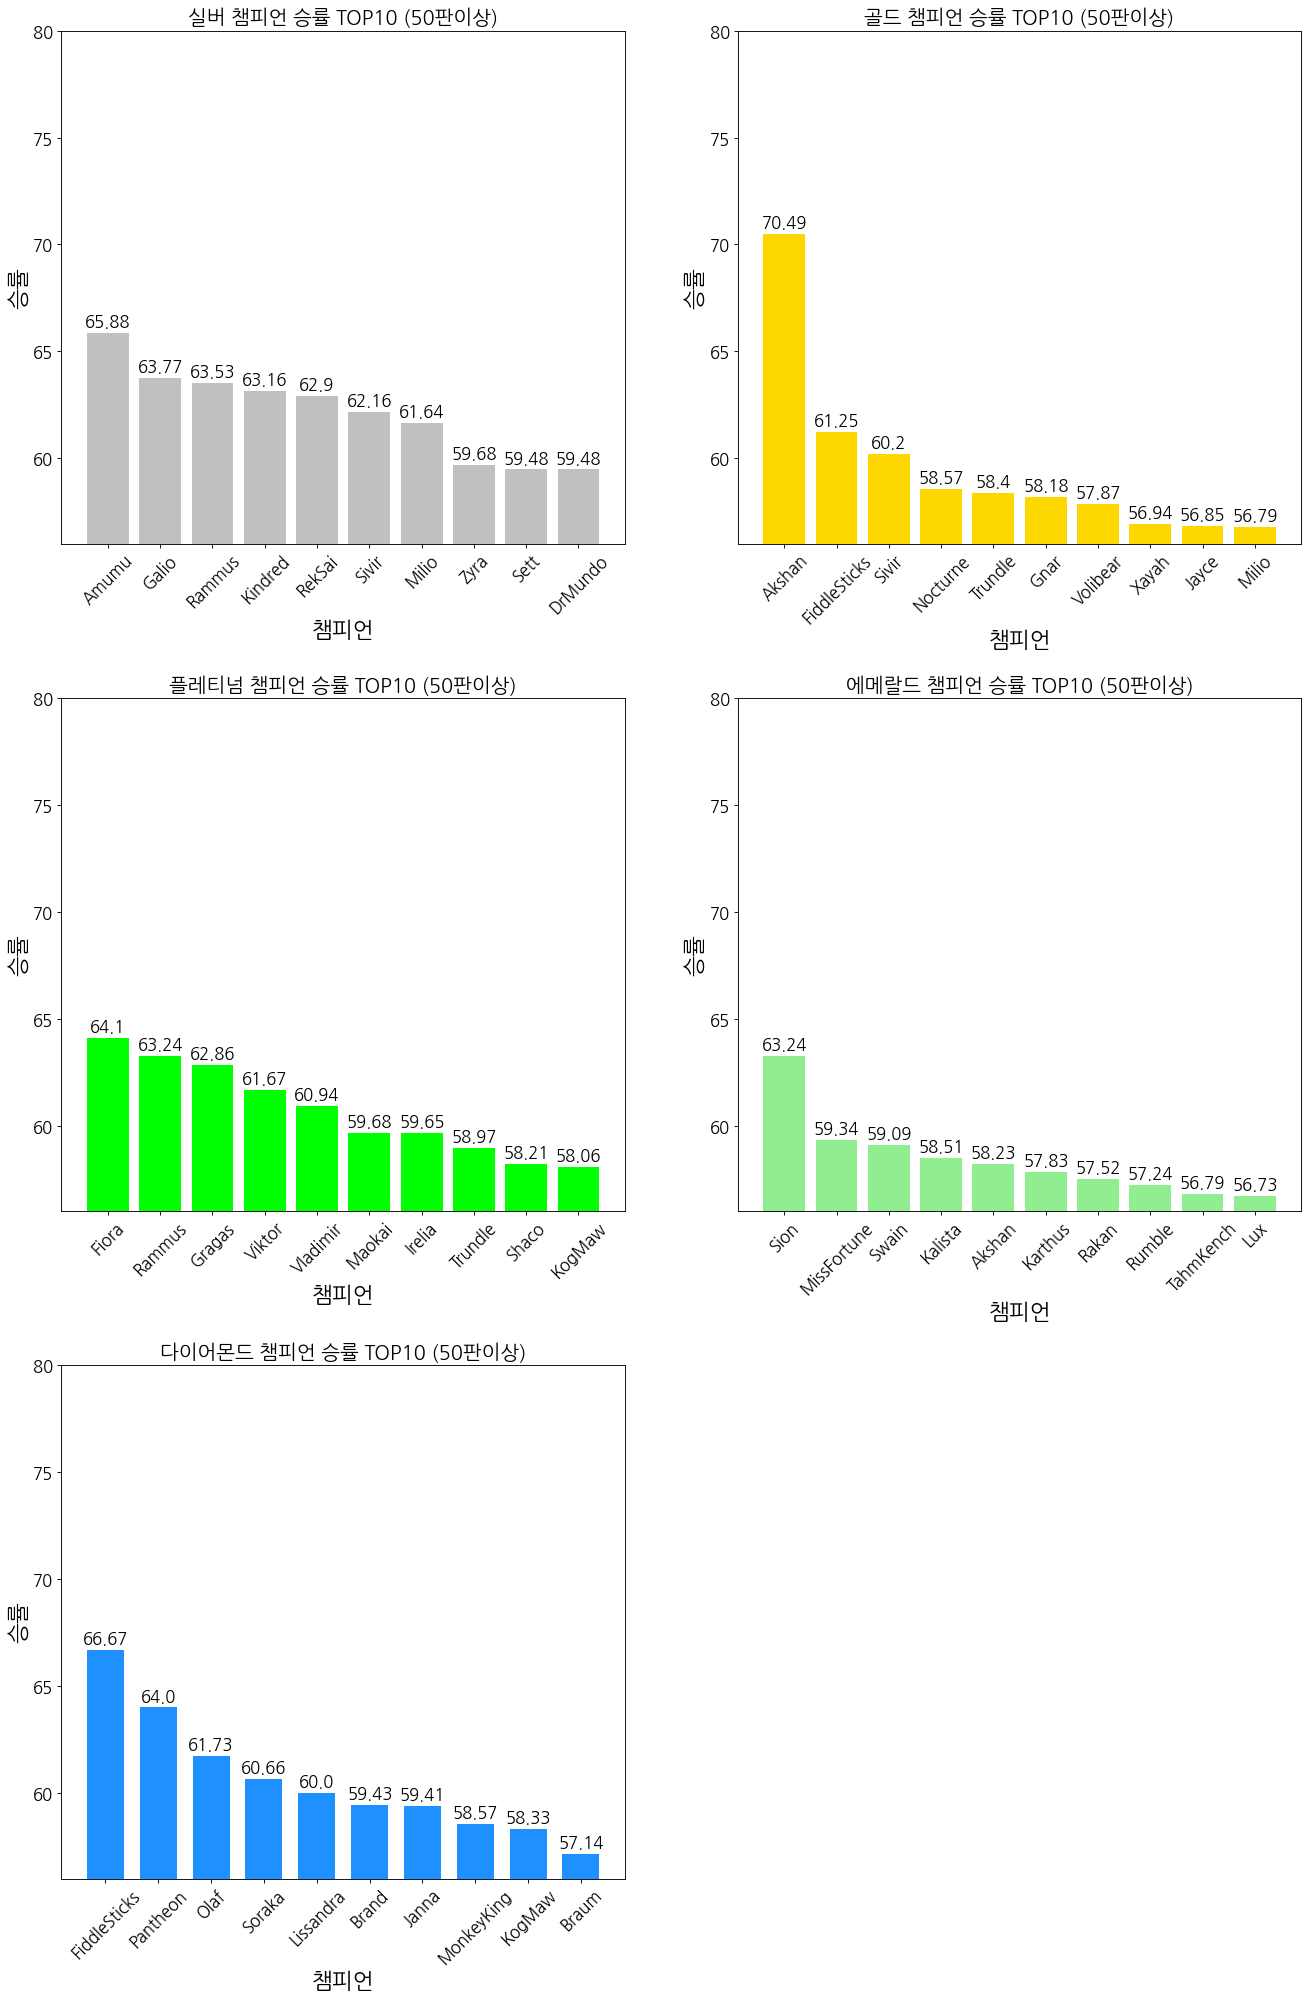

In [91]:
fig = plt.figure(figsize= (20,30),dpi = 80) # 기본적인 틀을 잡는다.
plt.subplots_adjust(hspace = 0.3, wspace = 0.2)

plt.rc('font', size=15) 
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)

SILVER = fig.add_subplot(3,2,1)
plt.xlabel('챔피언')
plt.ylabel('승률')
plt.title('실버 챔피언 승률 TOP10 (50판이상)')
plt.xticks(rotation = 45)
plt.ylim(56, 80)
for i, j in enumerate(df_SILVER_win.WINRATE) :
    plt.text(i, j+0.3,df_SILVER_win.WINRATE[i],ha = 'center')

GOLD = fig.add_subplot(3,2,2)
plt.xlabel('챔피언')
plt.ylabel('승률')
plt.title('골드 챔피언 승률 TOP10 (50판이상)')
plt.xticks(rotation = 45)
plt.ylim(56, 80)
for i, j in enumerate(df_GOLD_win.WINRATE) :
    plt.text(i, j+0.3,df_GOLD_win.WINRATE[i],ha = 'center')

PLATINUM = fig.add_subplot(3,2,3)
plt.xlabel('챔피언')
plt.ylabel('승률')
plt.title('플레티넘 챔피언 승률 TOP10 (50판이상)')
plt.xticks(rotation = 45)
plt.ylim(56, 80)
for i, j in enumerate(df_PLATINUM_win.WINRATE) :
    plt.text(i, j+0.3,df_PLATINUM_win.WINRATE[i],ha = 'center')

EMERALD = fig.add_subplot(3,2,4)
plt.xlabel('챔피언')
plt.ylabel('승률')
plt.title('에메랄드 챔피언 승률 TOP10 (50판이상)')
plt.xticks(rotation = 45)
plt.ylim(56, 80)
for i, j in enumerate(df_EMERALD_win.WINRATE) :
    plt.text(i, j+0.3,df_EMERALD_win.WINRATE[i],ha = 'center')

DIAMOND = fig.add_subplot(3,2,5)
plt.xlabel('챔피언')
plt.ylabel('승률')
plt.title('다이어몬드 챔피언 승률 TOP10 (50판이상)')
plt.xticks(rotation = 45)
plt.ylim(56, 80)
for i, j in enumerate(df_DIAMOND_win.WINRATE) :
    plt.text(i, j+0.3,df_DIAMOND_win.WINRATE[i],ha = 'center')

DIAMOND.bar(df_DIAMOND_win.CHAMPIONNAME,df_DIAMOND_win.WINRATE, color='dodgerblue',width=0.7)
EMERALD.bar(df_EMERALD_win.CHAMPIONNAME,df_EMERALD_win.WINRATE, color='lightgreen')
PLATINUM.bar(df_PLATINUM_win.CHAMPIONNAME,df_PLATINUM_win.WINRATE, color='lime')
GOLD.bar(df_GOLD_win.CHAMPIONNAME,df_GOLD_win.WINRATE, color='gold')
SILVER.bar(df_SILVER_win.CHAMPIONNAME,df_SILVER_win.WINRATE, color='silver')